In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
# from io import StringIO
# import re
# import csv

In [2]:
# nmrview .xpk files are nonstandard formatting with some columns in brackets
# otherwise space deliminated 
# bracketed columns: *.J *.U *.L comment

###### Functions
def read_xpk(file, header_lines=5):
    raw=pd.DataFrame()
    with open(file) as fp:
        for i, line in enumerate(fp):
            #Assuming header_lines is correct, convert that line to the column values
            if i == header_lines:
                xpk_columns = ['pk']+line.rstrip().replace('\t',' ').split(' ')
                raw = pd.DataFrame(columns=xpk_columns)
            #otherwise, get the data after the column names
            #break lines up to capture any curly bracketed content as a single cell entry
            #this retains the curly brackets so output matches what an xpk text file looks like
            elif (i > header_lines):                
                breaks = [0]
                for j,v in enumerate(line):
                    if v == "{":
                        breaks += [j]
                    if v == "}":
                        breaks += [j+1]
                breaks += [len(line)]

                items = []
                for k in range(len(breaks)-1):
                    item=line[breaks[k]:breaks[k+1]]
                    if item[0] == "{":
                        items.append(item)
                    else: 
                        for j,v in enumerate(item.split()):
                            items.append(v)
                #print (items)             
                raw.loc[len(raw)]=items
    return raw

def get_ddhnavg(data,scale_n = 5.0,samples=None,uselabel='HN'):
    if samples == None:
        samples = list(data['sample'].unique())
    reference = samples[0]
    #samples = [reference] + [x for x in samples if x not in reference]
    label = 'HN.L' if uselabel in ['HN','hn','h'] else '15N.L'
    ref_residues = list(data[label][data['sample']==reference].unique())
    if '' in ref_residues: ref_residues.remove('')
    #ref_residues.sort()
    csps = pd.DataFrame()
    csps['residue']=ref_residues
    csps['resid']=[x.split('.')[0] for x in csps['residue']]
    csps['resid']=csps['resid'].astype(int)
    for i,sample in enumerate(samples):
        df = data.copy()[data['sample']==sample]
        hdict = dict([(i,x) for i,x in zip(df[label], df['HN.P'])])
        ndict = dict([(i,x) for i,x in zip(df[label], df['15N.P'])])
        csps['HN_'+str(i)]=csps.get('HN_'+str(i),csps['residue'].map(hdict)).astype(np.float16)
        csps['N_'+str(i)]=csps.get('N_'+str(i),csps['residue'].map(ndict)).astype(np.float16)
    for i in range(1,len(samples)):
        csps['ddHN_'+str(i)] = csps['HN_'+str(i)]-csps['HN_0']
        csps['ddN_'+str(i)] = csps['N_'+str(i)]-csps['N_0']
        csps['ddHNavg_'+str(i)]=np.sqrt(csps['ddHN_'+str(i)]**2 + (csps['ddN_'+str(i)]/scale_n)**2)
    csps = csps.sort_values(by=['resid','residue'],ascending=[True,False],ignore_index=True)
    return samples, csps

######## end Functions

#Get the data

Header_Lines = 5
#project_dir = '/home/tuttle/data/nmrdata/gal4'
project_dir = '/home/tuttle/data/nmrdata/ABD1_cAD/15Nhsqc'

xpk_files = [ f for f in os.listdir(project_dir) if f[-4:]=='.xpk'  ]
samples = [ff[:-4] for ff in xpk_files] 

# this will join all xpk file data in the project_dir into one dataframe 
# works even if mixed dimensions (e.g. HSQCs + HNCACB)
all_xpks = pd.DataFrame()
for file in xpk_files:
    test_xpk = read_xpk(os.path.join(project_dir,file),header_lines=Header_Lines)
    test_xpk['sample']=file[:-4]
    all_xpks = pd.concat([all_xpks,test_xpk], ignore_index=True,axis=0)

#to remove curly brackets from entries 
all_xpks = all_xpks.replace('{|}','',regex=True)




In [3]:
#Analyze the data

#samples = ['gal4_828-881_ABD1_ratioInf','gal4_828-881_ABD1_ratio0p24']
samples = ['abd1_hsqc_c', 'abd1_cAD_10to1','abd1_cAD_5to1', 'abd1_cAD_2to1','abd1_cAD_1to1', 'abd1_cAD_1to2', 'abd1_cAD_1to3', 'abd1_cAD_1to5', ]
keep_cols = ['sample','pk','HN.L','HN.P','15N.L','15N.P']
focal_data = all_xpks[keep_cols].copy()[all_xpks['sample'].isin(samples)]
# focal_data['sample'] = focal_data['sample'].astype("category")
# focal_data['sample'] = focal_data['sample'].cat.set_categories(samples)
#focal_data.sort_values(by=['sample'])
#focal_data.head()

samples, csp_data = get_ddhnavg(focal_data,samples=samples)
#print(samples)



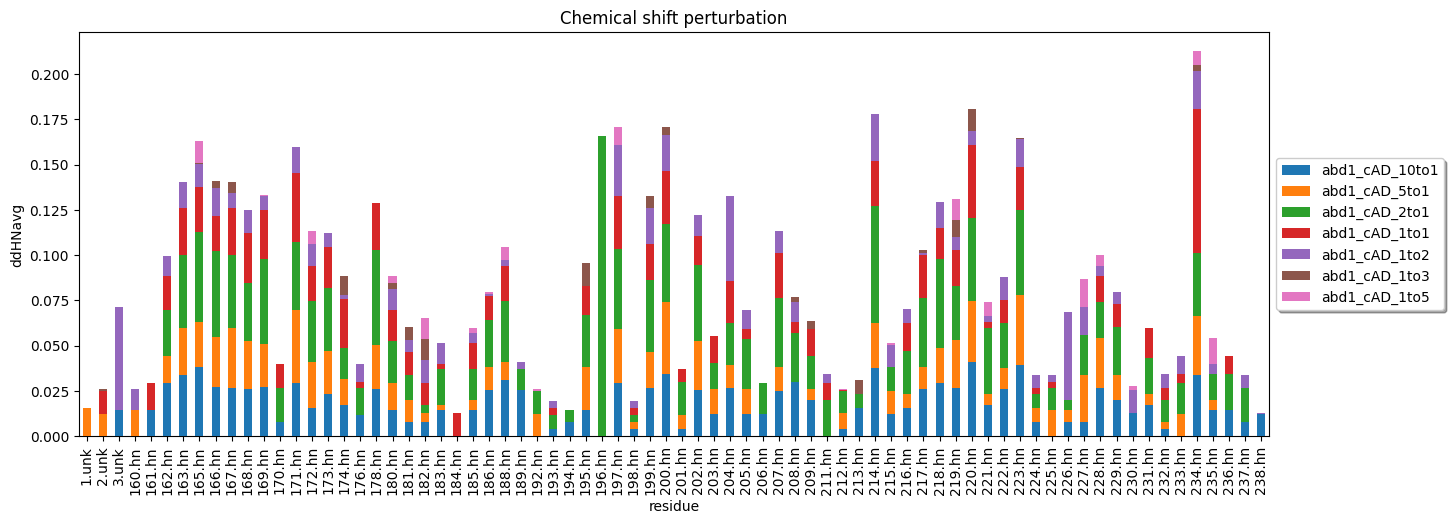

In [4]:
#Plot the data 
# import matplotlib.colors
# from cycler import cycler

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


csp_data = csp_data[csp_data['resid']!=175]
csp_data.set_index("residue",drop=False,inplace=True)
fig, axes = plt.subplots(figsize=(14, 6), ncols=1,nrows=1)# nrows=len(samples)-1,)
fig.tight_layout(pad=6.0)
y_value = 'ddHNavg'
y_values = [y_value+'_'+str(i) for i in range(1,len(samples))]
#x_labels = list(csp_data.residue);

for i in range(len(samples)-1):
    csp_data[y_values[i]].plot(x="residue",kind="bar",ax=axes,color=colors[i],zorder=10-i,label="residue",alpha=1.0)
axes.set_title("Chemical shift perturbation")
axes.set_ylabel(y_value);
#axes.set(ylim=(0,0.2))
axes.legend(samples[1:],bbox_to_anchor=(1,0.5),loc='center left',fancybox=True,shadow=True);

# if len(samples) > 2:
#     for i in range(1,len(samples)):
#         csp_data.plot(x="residue",y=y_value+'_'+str(i),kind="bar",ax=axes[i-1])
#         axes[i-1].set_title("Chemical shift perturbation, sample="+str(samples[i]))
#         axes[i-1].set_ylabel(y_value);
#         axes[i-1].set(ylim=(0,0.2))
# else:
#     for i in range(1,len(samples)):
#         csp_data.plot(x="residue",y=y_value+'_'+str(i),kind="bar",ax=axes)
#         axes.set_title("Chemical shift perturbation, sample="+str(samples[i]))
#         axes.set_ylabel(y_value);
#         axes.set(ylim=(0,0.2))


In [339]:
def get_sparky(data,list=None,F1='HN',F2='15N',F3=None,addpadding = True):
    '''
    Defaults assume 15NHSQC type peak lists. 
    F1,2,3 must match what is read in from the xpk.    

      
    Assignment          w1         w2
            ?-?    118.702      7.671
            ?-?    116.775      7.526
            ?-?    120.399      7.895
    
    '''
    dims = 2
    label = {}
    label[1] = F1 #'HN' if F1 in ['HN','hn','h'] else F1
    label[2] = F2 #'15N' if F2 in ['N','15N','n'] else F2

    if F3 != None: 
        label[3] = F3
        dims = 3

    if list == None:
        if data['sample'].nunique() > 1:
            print("Choose a sample to output\n")
            print("Options are: \n",list(data['sample'].unique()))
            return
        else: reference = data['sample'].unique()[0]
    else: reference = list  

    sparky = pd.DataFrame()

    for dim in range(1,dims+1):
        sparky['label'+str(dim)]= data.copy()[data['sample']==reference][label[dim]+'.L']
        sparky['label'+str(dim)]=sparky['label'+str(dim)].str.split('.',n=1).str[0]+sparky['label'+str(dim)].str.split('.',n=1).str[1]
        sparky['label'+str(dim)]=sparky['label'+str(dim)].str.split(' ',n=1).str[0]
        sparky['w'+str(dim)] = data.copy()[data['sample']==reference][label[dim]+'.P'].astype('float')
    sparky.fillna(value='?',inplace=True)
    sparky['Assignment'] = '     ' + sparky['label1'] + '-' + sparky['label2']
    if dims == 3: sparky['Assignment'] = sparky['Assignment']+ '-' + sparky['label3']

    keepcols = ['Assignment'] + ['w'+str(i) for i in range(1,dims+1)]
    #print(keepcols)
    sparky = sparky[keepcols]
    if addpadding:        
        sparky['Assignment'] = sparky['Assignment'].map('{:>17}'.format)
        sparky['w1'] = sparky['w1'].map('{:>8.3f}'.format)
        sparky['w2'] = sparky['w2'].map('{:>8.3f}'.format)
        padded_columns = {'Assignment':'Assignment '.rjust(17,' '), 'w1':'w1'.rjust(8,' '), 'w2':'w2'.rjust(8,' ')}
        if dims == 3: 
            sparky['w3'] = sparky['w3'].map('{:>8.3f}'.format)
            padded_columns = padded_columns | {'w3':'w3'.rjust(8,' ')}
        sparky.rename(columns=padded_columns,inplace=True)     

    return sparky


In [288]:
sparky_list = pd.DataFrame()
sparky_list = get_sparky(all_xpks,list='abd1_hsqc_c')

#sparky_list.columns
sparky_list.to_csv('sparky_list_test.list', sep = '\t', index = False)
print(sparky_list)

HN 15N None
Empty DataFrame
Columns: [      Assignment ,       w1,       w2]
Index: []


In [270]:
#Get the data

Header_Lines = 5
project_dir = '/home/tuttle/data/nmrdata/gal4'
#project_dir = '/home/tuttle/data/nmrdata/ABD1_cAD/15Nhsqc'

xpk_files = [ f for f in os.listdir(project_dir) if f[-4:]=='.xpk'  ]
samples = [ff[:-4] for ff in xpk_files] 

# this will join all xpk file data in the project_dir into one dataframe 
# works even if mixed dimensions (e.g. HSQCs + HNCACB)
all_xpks = pd.DataFrame()
for file in xpk_files:
    test_xpk = read_xpk(os.path.join(project_dir,file),header_lines=Header_Lines)
    test_xpk['sample']=file[:-4]
    all_xpks = pd.concat([all_xpks,test_xpk], ignore_index=True,axis=0)

#to remove curly brackets from entries 
all_xpks = all_xpks.replace('{|}','',regex=True)



In [340]:
all_xpks['sample'].unique()
list = 'hncacb_gal4'
list_xpk = all_xpks.copy()[all_xpks['sample']==list]
list_xpk.dropna(how='all',axis='columns')

sparky_list = pd.DataFrame()
sparky_list = get_sparky(all_xpks,list='hncacb_gal4',F1='HN',F2='15N',F3='13C') #abd1_hsqc_c'

#sparky_list.columns
sparky_list.to_csv('sparky_list_test.list', sep = '\t', index = False)
print(sparky_list)

               Assignment         w1        w2        w3
572       881hn-881n-881ca     8.015   127.668    58.360
573       881hn-881n-881cb     8.017   127.619    31.120
574       880hn-880n-880ca     8.337   124.091    56.554
575       880hn-880n-880cb     8.337   124.083    33.116
576       879hn-879n-879ca     8.317   121.407    56.552
..                     ...       ...       ...       ...
678       862hn-862n-862cb     8.265   120.990    41.626
679       864hn-864n-863ca     7.882   119.027    54.292
680       864hn-864n-863cb     7.886   119.037    40.971
681       863hn-863n-863ca     8.248   120.255    54.769
682       863hn-863n-863cb     8.248   120.243    41.039

[111 rows x 4 columns]


In [312]:
x = {'a':'A'}
x = x | {'b':'B'}
print (x)

{'a': 'A', 'b': 'B'}
